Author: Carlos Roberto de Melo

Date: 05/27/2020
    
Obj: Construct the velocity dispersion map/Construir o mapa de dispersão de velocidade

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot

from scipy.interpolate import interp2d
import scipy.interpolate
from scipy import ndimage

from plotbin.sauron_colormap import register_sauron_colormap

from mpdaf.obj import Image, WCS

data_folder = "/home/carlos/Desktop/ESO"

In [2]:
Bin, vel, disp, chi2, dV, dsigma = np.loadtxt('Output_Ppxf_IndoTemplate.txt', unpack=True) #Reads the table with the adjustment data/Lê a tabela com os dados do ajuste

vel = vel - vel[0]                                   #vel[0] velocity of central px
vrms = np.sqrt(np.array(vel)**2 + np.array(disp)**2) #Vrms velocity
erms = np.sqrt((np.array(dV)*np.array(vel))**2 + (np.array(dsigma)*np.array(disp))**2)/vrms #error in vrms

In [3]:
grid = Image(data_folder+'/Data/Annealing_tag.fits')

for i in range(len(Bin)):
    
    pos = np.where(grid.data.data == i)
    grid.data.data[pos] = vrms[i]
    grid.var.data[pos] = erms[i]

grid.write(data_folder+'/Data/Vrms_Map.fits')

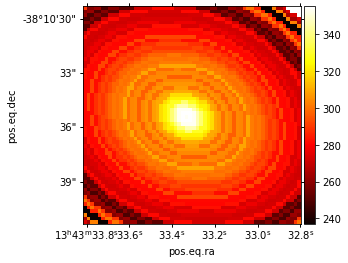

In [4]:
grid.plot(use_wcs=True, zscale=True, colorbar='v', cmap='hot')

In [5]:
y = [] #y position in px value/Posição y em valor de px
x = [] #x position in px value/Posição x em valor de px
vrms = [] #vrms velocity /dispersão de velocidade

for i in range (grid.shape[0]):
    for j in range(grid.shape[1]):
        y.append(i)
        x.append(j)
        vrms.append(grid.data.data[i,j])

x_new = np.transpose(x) 
y_new = np.transpose(y)
vrms = np.transpose(vrms)
for i in range(len(vrms)):
    if np.isnan(vrms[i]):
        vrms[i] = 0

In [6]:
def plot_velfield(x, y, vel, vmin=None, vmax=None, ncolors=64,
                  nodots=False, colorbar=False, linescolor='k', label=None, 
                  flux=None, nticks=7, markersize=3, cmap=plt.cm.hot, **kwargs):

    x, y, vel, flux = map(np.ravel, [x, y, vel, flux])

    assert x.size == y.size == vel.size, 'The vectors (x, y, vel) must have the same size'

    if cmap in ['sauron', 'sauron_r']:
        register_sauron_colormap()

    if vmax is None and vmin is None:
        vmin, vmax = np.min(vel), np.max(vel)
        extend = 'neither'
    elif vmax is None:
        vmax = np.max(vel)
        extend = 'min'
    elif vmin is None:
        vmin = np.min(vel)
        extend = 'max'
    else:
        extend = 'both'

    levels = np.linspace(vmin, vmax, ncolors)

    ax = plt.gca()

    cnt = ax.tricontourf(x, y, vel, levels=levels, cmap=cmap, extend=extend, **kwargs)

    for c in cnt.collections:    # Remove white gaps in contour levels of PDF
        c.set_edgecolor("face")  # http://stackoverflow.com/a/32911283/

    ax.axis('image')  # Equal axes and no rescaling
    ax.minorticks_on()
    ax.tick_params(length=10, which='major')
    ax.tick_params(length=5, which='minor')

    if flux[0] is not None:
        ax.tricontour(x, y, -2.5*np.log10(flux/np.max(flux).ravel()),
                      levels=np.arange(20), colors=linescolor)  # 1 mag contours

    if not nodots:
        ax.plot(x, y, '.k', markersize=markersize, **kwargs)

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        ticks = MaxNLocator(nticks).tick_values(vmin, vmax)
        cbar = plt.colorbar(cnt, cax=cax, ticks=ticks)
        if label is not None:
            cbar.set_label(label)
        plt.sca(ax)  # Activate main plot before returning

    return cnt

<Figure size 432x288 with 0 Axes>

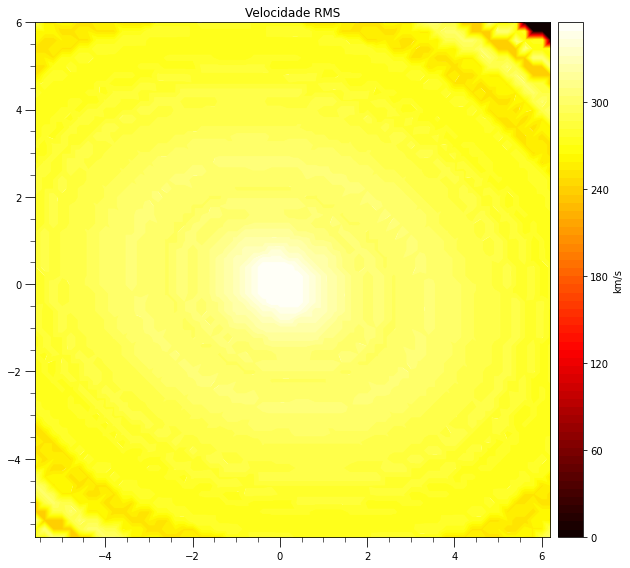

In [9]:
#Plot the velocity dispersion map/Plota o mapa de dispersão de velocidade
plt.clf()
plt.figure(figsize=(10,8))
plt.title('Velocidade RMS')
plot_velfield((x_new-28)*0.2,(y_new-29)*0.2, vrms, colorbar=True, label='km/s', nodots=True)

#plt.xlim(-3,3)
#plt.ylim(-3.5,3.5)
plt.tight_layout()
plt.show()

In [8]:
xi, yi = np.linspace(x_new.min(), x_new.max(), 100), np.linspace(y_new.min(), y_new.max(), 100)
xi, yi = np.meshgrid(xi, yi)
rbf = scipy.interpolate.Rbf(x_new, y_new, vrms, function='cubic')
zi = rbf(xi, yi)

Text(0.5, 0.98, 'SDP81 Velocity RMS Map')

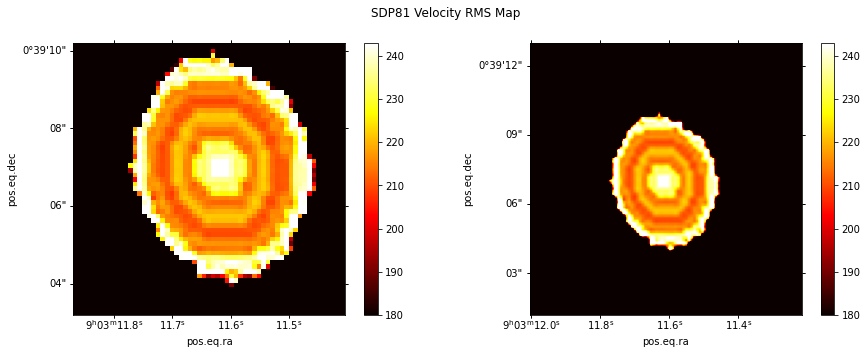

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': grid.wcs.wcs}, figsize=(15,5))


fig.add_subplot(ax1, projection=grid.wcs.wcs)

img1 = ax1.imshow(zi, vmin=180, vmax=vrms.max(), origin='lower',
           extent=[x_new.min(), x_new.max(), y_new.min(), y_new.max()], cmap=plt.cm.hot)

img2 = ax2.imshow(zi, vmin=180, vmax=vrms.max(), origin='lower',
           extent=[x_new.min(), x_new.max(), y_new.min(), y_new.max()], cmap=plt.cm.hot)

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)

plt.xlim(10,45)
plt.ylim(10,45)
fig.suptitle('SDP81 Velocity RMS Map')

In [ ]:
xi, yi = np.linspace(x_new.min(), x_new.max(), 180), np.linspace(y_new.min(), y_new.max(), 180)
xi, yi = np.meshgrid(xi, yi)
rbf = scipy.interpolate.Rbf(x_new, y_new, vrms, function='gaussian')
zi = rbf(xi, yi)

fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': grid.wcs.wcs}, figsize=(15,5))


fig.add_subplot(ax1, projection=grid.wcs.wcs)

img1 = ax1.imshow(zi, vmin=180, vmax=vrms.max(), origin='lower',
           extent=[x_new.min(), x_new.max(), y_new.min(), y_new.max()], cmap=plt.cm.hot)

img2 = ax2.imshow(zi, vmin=180, vmax=vrms.max(), origin='lower',
           extent=[x_new.min(), x_new.max(), y_new.min(), y_new.max()], cmap=plt.cm.hot)

plt.colorbar(img1, ax=ax1)
plt.colorbar(img2, ax=ax2)

plt.xlim(18,40)
plt.ylim(18,40)
fig.suptitle('SDP81 Velocity RMS Map')